In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import json
from shapely.geometry import Polygon
%matplotlib inline
from shapely.ops import cascaded_union
from geopandas import GeoSeries #вообще нахер не нужный мусор, засоряющий память
import pyproj # для конвертации координат в плоскость, хотя тут нужно уточнить
import math #эта шляпа нужна для синусов / косинусов и углов
import descartes #хз зачем это
from pylab import cm #это ещё чт за говно... Вроде как не понадобилось

# Создание сетки

Здесь куча джигурды-пояснений

#### Типа задаем параметры

In [61]:
# Директория с данными сетки
grid_data_dir = 'BatyaGritMalatsa/'

# Имя полигона города, который хранится в 
city_polygon = 'batyas_place2.geojson'

# Задаем длину квадрата
width = 100

# Собсна загружаем полигон

In [62]:
#Здесь в работу вступает модуль pyproj.Proj и я ес чесн хз что он делает
# wgs84 -- 3D sphere model of Earth, читал про неё на днях. Типа это стандарт, по которому работает GPS
wgs84 = pyproj.Proj("+init=EPSG:4326") # LatLon with WGS84 datum used by GPS units and Google Earth -- хорошо, а как насчёт яндекса?
pm = pyproj.Proj("+init=EPSG:32646") # Для КРСКа выбираем спец UTM зону - хмммммммм

In [63]:
#ну грузим полигон, чо
with open(grid_data_dir + city_polygon, encoding = 'utf-8') as k:
    krsk_file = json.load(k) #выглядит как словарь

In [64]:
krsk_file

{'type': 'FeatureCollection',
 'metadata': {'name': 'Без названия', 'creator': 'Yandex Map Constructor'},
 'features': [{'type': 'Feature',
   'id': 0,
   'geometry': {'type': 'Polygon',
    'coordinates': [[[92.818280420654, 55.99686289191914],
      [92.85398598706024, 56.006097172116775],
      [92.8993045905759, 56.012636779988604],
      [92.90205117260714, 56.02417455285036],
      [92.92539711987278, 56.03071108773877],
      [92.9343235114743, 56.03801531162784],
      [92.97346230541963, 56.04454949328903],
      [92.9947483161618, 56.054156565597694],
      [93.00642128979462, 56.0733635029933],
      [92.9370700935056, 56.08948990571171],
      [92.78600808178685, 56.04224343840255],
      [92.818280420654, 55.99686289191914]]]},
   'properties': {'description': 'Левый берег',
    'fill': '#ed4543',
    'fill-opacity': 0.6,
    'stroke': '#ed4543',
    'stroke-width': '5',
    'stroke-opacity': 0.9}},
  {'type': 'Feature',
   'id': 1,
   'geometry': {'type': 'Polygon',
    '

In [65]:
len(krsk_file['features'])

3

In [66]:
krsk_file['features'][2]['geometry']['coordinates'][0]

[[92.9040671072308, 56.01187466974887],
 [92.92878634551201, 56.0132209482857],
 [92.94972903350029, 56.02302812693292],
 [92.96929843047295, 56.03225612832006],
 [92.98062808135188, 56.03302502845476],
 [92.9974508962933, 56.042250630412674],
 [92.99298770049248, 56.046093977612365],
 [92.98612124541437, 56.046862600917805],
 [92.97376162627377, 56.04244280690365],
 [92.94251925566829, 56.0362926824365],
 [92.93256289580498, 56.0289881311507],
 [92.90921694853934, 56.02091306463708],
 [92.9040671072308, 56.01187466974887]]

In [67]:
#Дальше идёт объединение полигонов, но надо ли мне их объединять? Сделаем это по приколу
#####Дальше конвертация из объемных в плоские координаты
gathering_into_union = []
for part in range(len(krsk_file['features'])):
    # Грузим все части Красноярска, хотя там всего одна ЛОЛ... Ну в первоначальном... Теперь вот три
    krsk_part = krsk_file['features'][part]['geometry']['coordinates'][0] #докапываемся до координат полигона
    # Transform to 2d coords and make polygons
    # x for lon and y for lat
    krsk_part_coords = []
    for i in range(len(krsk_part)):
        ####### input in format (lon, lat) - ну это и так понятно
        x, y = pyproj.transform(wgs84, pm, krsk_part[i][0], krsk_part[i][1]) #трансформируем гео координаты в x и y
        krsk_part_coords.append([x,y]) #добавляем
    krsk_part_polygon = Polygon(krsk_part_coords) #в игру вступает модуль shapely.geometry
    gathering_into_union.append(krsk_part_polygon) #таким образом получаем лист полигонов... Вроде как даже захешированных
# Собираем все части Красноярска в один полигон... а зачем?
krsk = cascaded_union(gathering_into_union) #из нескольких полигонов в листе собирается 1, функция берется из shapely.ops

#Сейчас данные сконвертированы из объемных координат в плоские

In [68]:
#чтоб не забывал, что такое krsk
type(krsk)

shapely.geometry.multipolygon.MultiPolygon

## Ну, считаем квадратную сетку

In [69]:
def calculate_grid(startx, starty, endx, endy, step):
    """
    Тут кароч Батя считает сетку. Вроде как логично: топаем слева направо, снизу вверх на известный шаг.
    Возвращает GeoDataFrame, каждая строка - полигон сетки (квадратик) 
    """
    #в оригинале здесь идёт куча шляпы,связанной с шестиугольниками, но я обойдусь без этого
    
    origx = startx #сохраняем оригиналы
    origy = starty
    
    polygons = [] #пустой список для хренения координат квадратов
    row = 1 #номер ряда
    #counter = 0 #счётчик - нахер не нужный, т.к. нигде не используется
    
    while starty < endy: # ...то есть всегда???
        startx = origx
        while startx < endx:
            p1x = startx
            p1y = starty
            p2x = startx + step
            p2y = starty
            p3x = startx + step
            p3y = starty + step
            p4x = startx
            p4y = starty + step
            square_poligon = [ #мутим лист кортежей из координат, замкнутую фигуру. В нашем случае - квадрат
                (p1x, p1y),
                (p2x, p2y),
                (p3x, p3y),
                (p4x, p4y),
                (p1x, p1y)]
            polygons.append(square_poligon)
            #counter += 1 # ну так и выброси его нахрен
            startx += step
        row += 1
        starty += step
        
    '''
    вообще, в этом блоке я добавляю линейное преобразование в виде умножения координат на ортогональную матрицу
    '''

    sth = [Polygon(polygons[i]) for i in range(len(polygons))] #какой то генератор. Polygon принимает на вход лист координат одного полигона и лепит полигон
    grid = gpd.GeoDataFrame({'geometry':sth}) #Прикольно, мы заворачиваем в геодатафрейм словарь с единсвтенным ключом
    
    return grid

In [70]:
# для размера сетки нужны стороны прямоугольника
minx, miny, maxx, maxy = krsk.bounds #Метод bounds вызывается от класса shapely.geometry.multipolygon.MultiPolygon

In [71]:
krsk.bounds #типа крайние точки полигона

(484403.27941038157, 6196273.140875499, 510514.779133858, 6216041.428746376)

#### Поехали, рисуем простую сетку

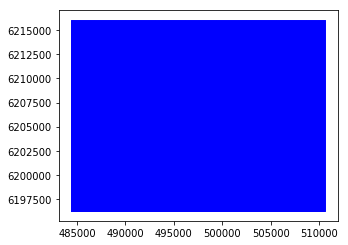

In [72]:
ordinary_grid = calculate_grid(minx, miny, maxx, maxy, width)
ordinary_grid.plot(color = 'white', edgecolor = 'blue', figsize = (5, 5)) #т.к. это геодатафрейм, то его можно нарисовать

In [73]:
#посмотри, что получилось
ordinary_grid.head(6)

,geometry
0,"POLYGON ((484403.2794103816 6196273.140875499,..."
1,"POLYGON ((484503.2794103816 6196273.140875499,..."
2,"POLYGON ((484603.2794103816 6196273.140875499,..."
3,"POLYGON ((484703.2794103816 6196273.140875499,..."
4,"POLYGON ((484803.2794103816 6196273.140875499,..."
5,"POLYGON ((484903.2794103816 6196273.140875499,..."


#### Дальше самое веселое - сопоставляем исходный полигон с сеткой. На выходе сетка в форме города

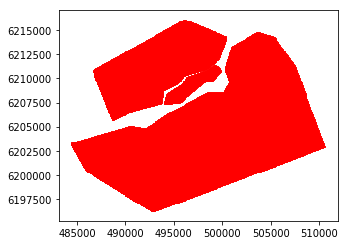

In [74]:
intersect_square = [] # список квадратов, которые получились в результате пересечения
for i in range(len(ordinary_grid)):
    #если пересечение границы города и сетки непустое, то включаем всю соту полностью - чегооооо????????
    if krsk.intersection(ordinary_grid.iloc[i][0]).area > 0.0: #метод от shapely.geometry.multipolygon.MultiPolygon
        intersect_square.append(ordinary_grid.iloc[i][0]) #ну то есть если непустой, то зааппедить
        
grid_intersect = gpd.GeoDataFrame({'geometry':intersect_square}) #снова формируем геодатафрейм
grid_intersect.plot(color='white', edgecolor='red', figsize=(5,5))
        

#### По приколу определим число квадратов

In [75]:
print(len(grid_intersect[grid_intersect['geometry'].notnull()]))
print(len(grid_intersect))

30976
30976


### И самое последнее - жопа - конвертация нашего 2d в 3d

In [76]:
#сперва напишем трансформирующую функцию, которая возвращает список
def transform_to_3d (grid):
    """
    grid - в данном случае полигоны сетки в виде GeoDataFrame
    proj3d_pols - список спроецированных в 3D полигонов сетки
    """
    proj3d_pols = []
    for i in range(len(grid)):
        try:
            xp, yp = grid.iloc[i][0].exterior.coords.xy #это ещё что такое?????????
            xp, yp = list(xp), list(yp) #трансформация верхних значений... в листы?
            x, y = pyproj.transform(pm, wgs84, xp, yp) #собсна вот наша трансформация из 2d в 3d... Уже прямая??... Дальше всё...
            proj3d_pols.append(Polygon([(x[j],y[j]) for j in range(len(x))]))
        except AttributeError: 
            try:
                for k in range(len(grid.iloc[i][0])):
                    xp, yp = grid.iloc[i][0][k].exterior.coords.xy
                    xp, yp = list(xp), list(yp)
                    x, y = pyproj.transform(pm, wgs84, xp, yp)
                    proj3d_pols.append(Polygon([(x[j],y[j]) for j in range(len(x))]))
            except AttributeError:
                continue
    return proj3d_pols

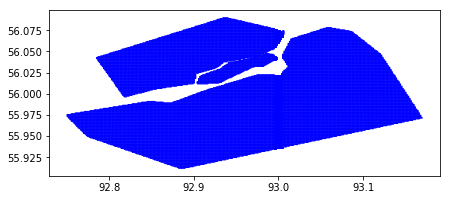

In [77]:
#ну и финал
grid_proj3d = gpd.GeoDataFrame({'geometry':transform_to_3d(grid_intersect)})
grid_proj3d.plot(color='white', edgecolor='blue', figsize = (7,7))

### Вот и всё! Экспортируем и наслаждаемся


In [78]:
with open(grid_data_dir + 'Krsk_hustle_100.json', 'w') as k:
    k.write(grid_proj3d.to_json())